## Behavioral Cloning P3
### Replicating Driving Style using Behavioural Cloning
In this project we seek to replicate my own driving style using behavioural cloning, using a deep neural network.

### *Update:*
*Originally I had implemented a deep reinforcement learning model with experience replay for this project.  Unfortunately after investigation the reward function used in training the Deep Q Network proved unreliable in computing the state errors (see [here](https://github.com/bdschrisk/CarND-Behavioral-Cloning-P3/blob/master/Behavioural-Cloning-CV.ipynb)).  To meet the deadline of this project I have instead used the below model...*

In [1]:
#importing some useful packages
import numpy as np
import pandas as pd
import cv2
import os
# import model configuration
import modelconfig as config

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# plotting function for images
def plot(images, no_rows, no_cols, width = 10., height = 4., color='gray', labels = []):
    fig = plt.figure(1, (width, height))
    i = 0
    
    for image in images:
        sub = fig.add_subplot(no_rows, no_cols, i + 1)
        sub.imshow(image, color)
        if (len(labels) > 0):
            sub.set_title(str(labels[i]), fontsize=9)
        sub.axis("off")
        i += 1

    plt.show()

### Steering Angle Resolution
In my architecture, the final output layers have hyperbolic tangent activation functions which produces outputs in the required range for the simulator.  Originally I had moved away from continuous single outputs in favour of a discretised steering angle range from -1 to +1, however this caused issues with learning due to bin allocations.  The activation function used in the output layer ensures that the network is impervious to any irregularities in the input stream and thus cannot corrupt the steering angle.  The predicted actions are also now tractable.

In [3]:
direct = 'images/'
files = os.listdir(direct)
print(files)

['center_2016_12_01_13_43_42_018.jpg', 'center_2016_12_01_13_43_50_656.jpg', 'center_2016_12_01_13_44_00_605.jpg', 'center_2016_12_01_13_44_22_090.jpg', 'center_2016_12_01_13_44_32_113.jpg', 'center_2016_12_01_13_44_34_240.jpg', 'center_2016_12_01_13_44_39_802.jpg', 'center_2016_12_01_13_44_49_823.jpg', 'center_2016_12_01_13_44_57_578.jpg', 'center_2016_12_01_13_44_58_805.jpg', 'center_2016_12_01_13_45_05_405.jpg', 'center_2016_12_01_13_45_23_432.jpg', 'center_2016_12_01_13_45_55_065.jpg', 'center_2016_12_01_13_45_58_702.jpg', 'center_2016_12_01_13_46_07_111.jpg', 'center_2016_12_01_13_46_13_604.jpg', 'center_2016_12_01_13_46_22_781.jpg', 'center_2016_12_01_13_46_22_988.jpg', 'center_2016_12_01_13_46_33_965.jpg', 'center_2016_12_01_13_46_37_511.jpg']


**Plot Sample Images**

*Plot some sample frames from the training set to visually understand the problem being solved.*

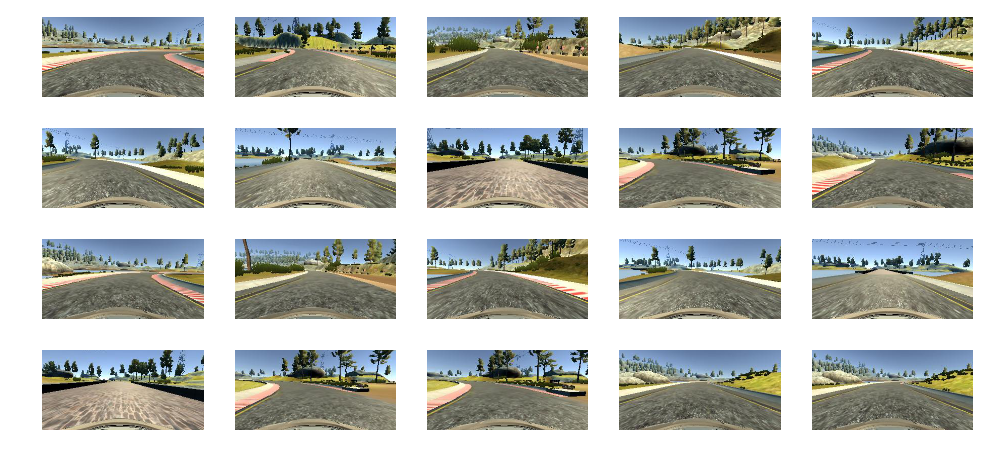

In [4]:
# load sample images and display
num_rows = 4
num_cols = 5
images = []

for file in files:
    image = mpimg.imread(os.path.join(direct, file))
    images.append(image)
plot(images, num_rows, num_cols, width=12., height=5.5)

**Load Data**

*The model.py script automatically splits the driving data into train / test data using stratified splitting - so let's load it up.*

In [5]:
train_file = "./data/TRAIN/training_data.csv"
test_file = "./data/TRAIN/testing_data.csv"

In [51]:
train_samples = np.array(pd.read_csv(train_file, sep=','))
test_samples = np.array(pd.read_csv(test_file, sep=','))
# extract into training / testing matrices
X_train = train_samples[:, 0]
y_train = train_samples[:, 1].astype(np.float)
X_test = test_samples[:, 0]
y_test = test_samples[:, 1].astype(np.float)

In [52]:
print("X_train shape = {}, Y_train shape = {}".format(X_train.shape, y_train.shape))
print("X_test shape = {}, Y_test shape = {}".format(X_test.shape, y_test.shape))

X_train shape = (12287,), Y_train shape = (12287,)
X_test shape = (5247,), Y_test shape = (5247,)


**Data Exploration**

*Let's explore the training and test data to ascertain driving statistics being fed into our model.*

[ 0.    0.    0.    0.   -0.05]


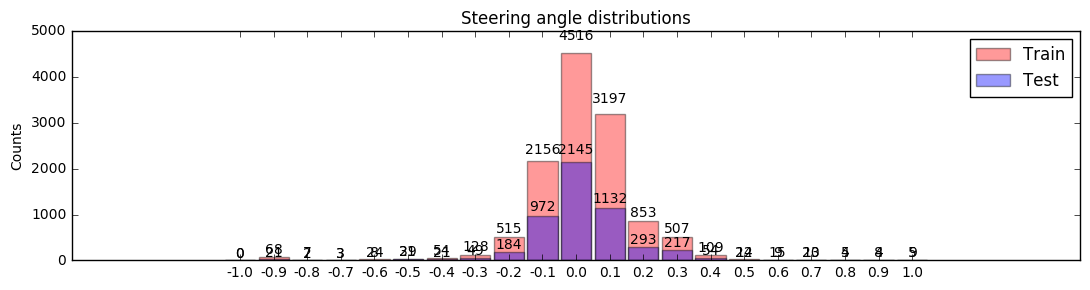

In [53]:
# find labels
train_counts = []
test_counts = []

num_bins = 21
bins = np.linspace(-1., 1., num_bins)
train_bin_ind = np.digitize(y_train, bins)
test_bin_ind = np.digitize(y_test, bins)

print(y_train[0:5])

for b in range(num_bins):
    train_count = (train_bin_ind == b).sum()
    train_counts.append(train_count)
    test_count = np.array(test_bin_ind == b).sum()
    test_counts.append(test_count)

# draw plots
width = 0.9

x = range(0, num_bins)
fig, ax = plt.subplots(figsize=(11,3))
rects1 = ax.bar(x, train_counts, width, alpha = 0.4, color='r', align='center')
rects2 = ax.bar(x, test_counts, width, alpha = 0.4, color='b', align='center')

# add some text for labels, title and axes ticks
ax.set_ylabel('Counts')
ax.set_title('Steering angle distributions')
ax.set_xticks(x)
ax.set_xticklabels(bins)

ax.legend((rects1[0], rects2[0]), ('Train', 'Test'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%d' % int(height), ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.tight_layout()
plt.show()

*As per the above graph we can see that the plot is weighted towards the right for steering angles in both the training and validation set.  However, as part of data generation, horizontal image shifts are created which evenly balances the steering for both left and right.*

### Model Architecture
*To learn the steering approximation function I've designed a deep neural network which is loosely based on the LeNet architecture, which I named "KaNet".*

In order to learn decent conceptual features of proper steering behaviour, an adequately deep neural network is required.  However, if the network is too shallow, it cannot learn higher order latent features.  This model does that, and is also not too deep as to cause common gradient issues found in deeper neural networks nor does it overfit the data.

The raw input image data is fed into a series of Input processing layers.  Sequentially, the input is first cropped to exclude the skyscape and then normalised, following this the input is resized to 50% across the width and height dimensions.  

After the preprocessing layers, repeating convolutional layers with 64, 32, 16 and 8 filters of 5x5, 3x3 and 2x2 detectors, consecutively, extract meaningful features from the input.  An average pooling layer downsamples each convolution into rectifiers for non-linearity, condensing the input into a final average pooling layer. The final pooling layer is responsible for extracting spatial respresentations from each convolution into a compressed output.  A global hidden layer of size 256 with parametric rectifiers provide latent features for extracting angles and throttle vectors.  Each output node is connected to its own hidden layer of size 128 with parametric rectifiers for identifying useful representations of its output.

Dropout layers were applied after each hidden activation layer, with a drop out rate of 20%.  I've also used L2 loss normalisation for weights and biases for lower layers.  Dropout was not applied to the convolutional layers as overfitting is generally caused by the dense upper layers in deep networks.

### Data Augmentation
In order to further prevent overfitting, the generator used to produce examples during training was built to induce noise into each sample with a random permutation between +30% and -30% of the average pixel intensity.  To compute this, the sample is first converted into the HSV colour range, then adding noise to the V channel only.  This theoretically introduces lighting changes into the original sample (see below).

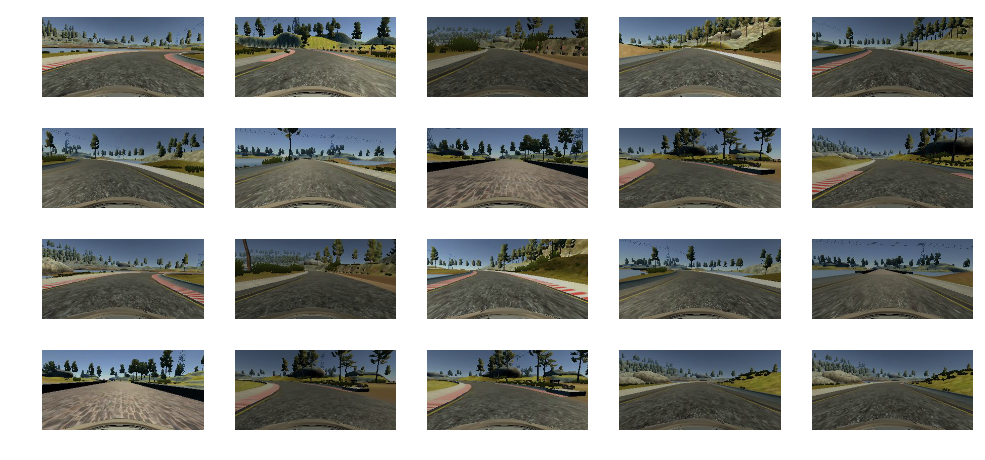

In [54]:
# Plot sample augmented images
import generator as g

images_aug = [g.add_image_noise(i, noise = 0.3) for i in images]
plot(images_aug, num_rows, num_cols, width=12., height=5.5)

### Training
Training the network was performed using the Adam optimiser with MSE loss, along with an initial learning rate of 0.001.  As part of training the network, a custom callback was used which prevents overfitting by monitoring the divergence between the training and validation loss metrics.

In [55]:
learning_graph = np.array(pd.read_csv("./model/training-loss.csv", sep=","))
train_acc = learning_graph[:,1].astype(np.float)
train_loss = learning_graph[:,2].astype(np.float)
val_acc = learning_graph[:,3].astype(np.float)
val_loss = learning_graph[:,4].astype(np.float)

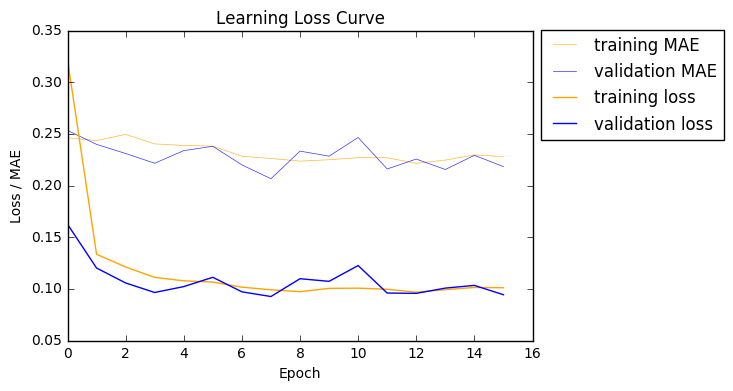

In [57]:
# Show learning curves
plt.plot(train_loss, color='orange', alpha = 0.8, linewidth = 0.5)
plt.plot(val_loss, color='blue', alpha = 0.8, linewidth = 0.5)
plt.plot(train_acc, color='orange')
plt.plot(val_acc, color='blue')
plt.title('Learning Loss Curve')
plt.ylabel('Loss / MAE')
plt.xlabel('Epoch')
plt.legend(['training MAE', 'validation MAE', 'training loss', 'validation loss'], \
           loc='outside', bbox_to_anchor=(1.0, 1.03))
plt.show()

In [59]:
print("Total training epochs: {}".format(len(train_loss)))
print("Final Training MAE/loss: {:.3f} | {:.2f}".format(train_loss[-1], train_acc[-1]))
print("Final Validation MAE/loss: {:.3f} | {:.2f}".format(val_loss[-1], val_acc[-1]))

Total training epochs: 16
Final Training MAE/loss: 0.228 | 0.10
Final Validation MAE/loss: 0.218 | 0.09


*After initially training and applying the model, it became apparent that the data recorded was not adequate for proper driving behaviour.  Following this, I recorded new training data using linear steering angle measurements from mouse input over the initial stepping, created from keyboard input used in the initial dataset.  I also recorded hard recovery data (perpendicular to the road) as well as intermediate recovery data (adjacent to the road edges) in the new dataset.*

*The new data also helped in balancing the training set across each label class as you can see from the data exploration graph above.  Training also improved as the correlation of the steering angle was able to be inferred more easily from the input images.*

__*Trained Model*__

As per the training / validation curve, the model required a number of epochs over the training set to converge to a decent optimum.  It seems the issue for the model to converge quickly is because of the mirror-like loss surface, i.e. the car needs to stay in the middle of the track, so when backprop pushes the magnitude / direction of the weights we overcompensate in the reverse steering angle and it bounces back and forth.

### Predictions
Below we compare some sample images comparing their predicted actions from the trained network and the actual steering angle recorded.

In [60]:
# define samples
number_of_samples = 20
random_sample = np.random.randint(0, len(X_test), size=number_of_samples)

In [61]:
# Load trained model
import kanet as kn
import modelconfig as config
import modelutils as mut

from keras.models import Model

# define model weights path
best_weights = mut.get_checkpoints(config.checkpoint_pattern)[0,0]

# construct KaNet model
model = kn.KaNet(config.img_dim, config.resize_factor, config.output_size, \
                 config.output_activation, config.dropout, config.weight_decay, 0)
# load weights
model.load_weights(best_weights)

Using TensorFlow backend.


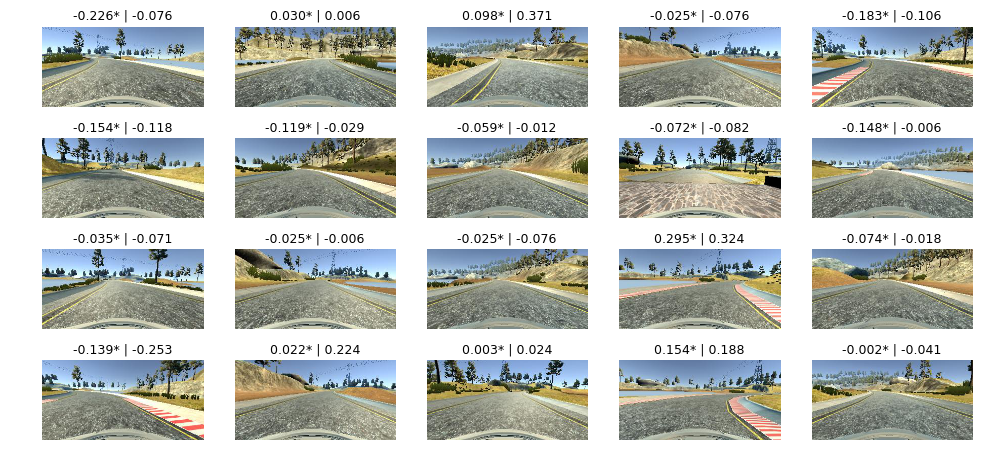

MSE = 0.203


In [64]:
# Show predictions (actual vs. pred)
pred_acc = 0.
predicted_images = []
predicted_labels = []
for sample in random_sample:
    # load image
    img = mpimg.imread(X_test[sample])
    angle = y_test[sample]
    # predict angle
    pred = model.predict(img[None,:,:,:])[0]
    pred_angle = pred[0]
    
    label = "{:.3f}* | {:.3f}".format(pred_angle, angle)
    predicted_images.append(img)
    predicted_labels.append(label)
    
    pred_acc += (pred_angle - angle) ** 2.

# plot predictions
plot(predicted_images, num_rows, num_cols, width=12., height=5.5, labels = predicted_labels)

print("MSE = {:.3f}".format(pred_acc))

*As per the above predictions (**** abbreviated), we can see that generally, the network is steering in the correct direction, however occassionally its a little off with the exact angle.*

#### Reflection
*This project was definitely the most rewarding of this term.  I've always wanted to implement a driving model using reinforcement learning.  The biggest issue I faced was coming up with a decent reward function.  While it started to learn to drive the reward sensitivity wasn't enough to converge fully.  I later attempted using the DenseNet architecture, however this proved not viable after testing due to the enormous computational complexity. I later changed the deep network to the one described herein, which was complex enough to capture higher level features and still remain computationally efficient.*

The limit of the original reinforcement learning model was the reward function, because of the pixelated nature of computer graphics, traditional CV techniques were difficult to apply well - atleast that I found.  In some cases the reward function lacked sensitivity in the environment meaning that rewards became corrupted for a given state.  One way to resolve this would be to apply state detectors over the road surface to match known surfaces and compute the likelihood estimation instead of the distance estimators that were used originally.

It would be beneficial to revisit this in the future and introduce recurrent layers in the top layers to give the model memory of the previous states and see how training improves.  Implementing vehicle and pedestrian detectors into the reinforcement learning model to see how well this end-to-end model can actually perform under real-life conditions would also be beneficial.